In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 2.3 MB/s eta 0:00:00


Below Cell to be Executed Only once, output then saved in drive (No need to run below code)

In [2]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import os
import shutil
import random

# Define paths
src_dir = "/content/drive/MyDrive/CWT_Spectrogram_Images"
dest_dir = "/content/drive/MyDrive/Split_CWT_Spectrogram_Images"

train_dir = os.path.join(dest_dir, "train")
test_dir = os.path.join(dest_dir, "test")

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Train-test split ratio
split_ratio = 0.8

# Iterate through class folders
for class_name in os.listdir(src_dir):
    class_path = os.path.join(src_dir, class_name)

    if os.path.isdir(class_path):
        # Create class folders in train and test directories
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Get all image file names
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(images)

        # Split images
        split_idx = int(len(images) * split_ratio)
        train_images = images[:split_idx]
        test_images = images[split_idx:]

        # Move images to respective directories
        for img in train_images:
            shutil.move(os.path.join(class_path, img), os.path.join(train_class_dir, img))

        for img in test_images:
            shutil.move(os.path.join(class_path, img), os.path.join(test_class_dir, img))

print("Dataset successfully split into train and test sets.")


Dataset successfully split into train and test sets.


In [ ]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.5/886.5 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


ViT CWT

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.transforms as T
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score
from sklearn.neighbors import kneighbors_graph
from PIL import Image

# Dataset paths
train_dir = "/content/drive/MyDrive/Split_CWT_Spectrogram_Images/train"
test_dir = "/content/drive/MyDrive/Split_CWT_Spectrogram_Images/test"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transform
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load ViT model for feature extraction
vit_model = models.vit_b_16(pretrained=True)
vit_model.heads = nn.Identity()
vit_model = vit_model.to(device).eval()

# Function to extract features
def extract_features(model, img_path):
    image = Image.open(img_path).convert("RGB")
    image = img_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image).cpu().numpy().flatten()
    return features

# Prepare dataset
def create_dataset(data_dir):
    features, labels, file_paths = [], [], []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(os.listdir(data_dir))}

    for cls_name in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls_name)
        if os.path.isdir(cls_path):
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                feat = extract_features(vit_model, img_path)
                features.append(feat)
                labels.append(class_to_idx[cls_name])
                file_paths.append(img_path)

    return np.array(features), np.array(labels), class_to_idx

# Extract train and test features
train_features, train_labels, class_map = create_dataset(train_dir)
test_features, test_labels, _ = create_dataset(test_dir)

# Print dataset sizes
print(f"Training Data: {train_features.shape[0]} samples")
print(f"Testing Data: {test_features.shape[0]} samples")

# Construct adjacency graph using k-NN
def create_graph(features, labels, k=5):
    adjacency_matrix = kneighbors_graph(features, k, mode="connectivity").toarray()
    edge_index = np.array(np.nonzero(adjacency_matrix))
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Create train and test graphs
train_graph = create_graph(train_features, train_labels)
test_graph = create_graph(test_features, test_labels)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Model, optimizer, loss function
gcn = GCN(in_channels=train_graph.x.shape[1], hidden_dim=128, out_channels=len(class_map)).to(device)
optimizer = optim.Adam(gcn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
def train(model, graph, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph.x.to(device), graph.edge_index.to(device))
        loss = criterion(out, graph.y.to(device))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Train the model
train(gcn, train_graph)

# Evaluate
gcn.eval()
with torch.no_grad():
    out = gcn(test_graph.x.to(device), test_graph.edge_index.to(device))
    pred = out.argmax(dim=1).cpu().numpy()

accuracy = accuracy_score(test_graph.y.numpy(), pred)
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Data: 960 samples
Testing Data: 240 samples
Epoch 0, Loss: 2.4450
Epoch 10, Loss: 0.2888
Epoch 20, Loss: 0.0974
Epoch 30, Loss: 0.0563
Epoch 40, Loss: 0.0425
Test Accuracy: 0.9583


ViT QFT

In [ ]:
import os
import shutil
import random

# Define paths
src_dir = "/content/drive/MyDrive/QFT_Spectrogram_Images_HighRes"
dest_dir = "/content/drive/MyDrive/QFT_Spectrogram_Images_HighRes"

train_dir = os.path.join(dest_dir, "train")
test_dir = os.path.join(dest_dir, "test")

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Train-test split ratio
split_ratio = 0.8

# Iterate through class folders
for class_name in os.listdir(src_dir):
    class_path = os.path.join(src_dir, class_name)

    if os.path.isdir(class_path):
        # Create class folders in train and test directories
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Get all image file names
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(images)

        # Split images
        split_idx = int(len(images) * split_ratio)
        train_images = images[:split_idx]
        test_images = images[split_idx:]

        # Move images to respective directories
        for img in train_images:
            shutil.move(os.path.join(class_path, img), os.path.join(train_class_dir, img))

        for img in test_images:
            shutil.move(os.path.join(class_path, img), os.path.join(test_class_dir, img))

print("Dataset successfully split into train and test sets.")

Dataset successfully split into train and test sets.


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.transforms as T
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score
from sklearn.neighbors import kneighbors_graph
from PIL import Image

# Dataset paths
train_dir = "/content/drive/MyDrive/QFT_Spectrogram_Images_HighRes/train"
test_dir = "/content/drive/MyDrive/QFT_Spectrogram_Images_HighRes/test"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transform
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load ViT model for feature extraction
vit_model = models.vit_b_16(pretrained=True)
vit_model.heads = nn.Identity()
vit_model = vit_model.to(device).eval()

# Function to extract features
def extract_features(model, img_path):
    image = Image.open(img_path).convert("RGB")
    image = img_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image).cpu().numpy().flatten()
    return features

# Prepare dataset
def create_dataset(data_dir):
    features, labels, file_paths = [], [], []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(os.listdir(data_dir))}

    for cls_name in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls_name)
        if os.path.isdir(cls_path):
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                feat = extract_features(vit_model, img_path)
                features.append(feat)
                labels.append(class_to_idx[cls_name])
                file_paths.append(img_path)

    return np.array(features), np.array(labels), class_to_idx

# Extract train and test features
train_features, train_labels, class_map = create_dataset(train_dir)
test_features, test_labels, _ = create_dataset(test_dir)

# Print dataset sizes
print(f"Training Data: {train_features.shape[0]} samples")
print(f"Testing Data: {test_features.shape[0]} samples")

# Construct adjacency graph using k-NN
def create_graph(features, labels, k=5):
    adjacency_matrix = kneighbors_graph(features, k, mode="connectivity").toarray()
    edge_index = np.array(np.nonzero(adjacency_matrix))
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Create train and test graphs
train_graph = create_graph(train_features, train_labels)
test_graph = create_graph(test_features, test_labels)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Model, optimizer, loss function
gcn = GCN(in_channels=train_graph.x.shape[1], hidden_dim=128, out_channels=len(class_map)).to(device)
optimizer = optim.Adam(gcn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
def train(model, graph, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph.x.to(device), graph.edge_index.to(device))
        loss = criterion(out, graph.y.to(device))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Train the model
train(gcn, train_graph)

# Evaluate
gcn.eval()
with torch.no_grad():
    out = gcn(test_graph.x.to(device), test_graph.edge_index.to(device))
    pred = out.argmax(dim=1).cpu().numpy()

accuracy = accuracy_score(test_graph.y.numpy(), pred)
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Data: 960 samples
Testing Data: 240 samples
Epoch 0, Loss: 2.6748
Epoch 10, Loss: 1.1015
Epoch 20, Loss: 0.8145
Epoch 30, Loss: 0.6504
Epoch 40, Loss: 0.5396
Test Accuracy: 0.9208


Both take about 5 minutes each using T4 GPU

swin cwt

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.transforms as T
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score
from sklearn.neighbors import kneighbors_graph
from PIL import Image

# Dataset paths
train_dir = "/content/drive/MyDrive/Split_CWT_Spectrogram_Images/train"
test_dir = "/content/drive/MyDrive/Split_CWT_Spectrogram_Images/test"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transform
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load ViT model for feature extraction
vit_model = models.swin_b(pretrained=True)
vit_model.heads = nn.Identity()
vit_model = vit_model.to(device).eval()

# Function to extract features
def extract_features(model, img_path):
    image = Image.open(img_path).convert("RGB")
    image = img_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image).cpu().numpy().flatten()
    return features

# Prepare dataset
def create_dataset(data_dir):
    features, labels, file_paths = [], [], []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(os.listdir(data_dir))}

    for cls_name in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls_name)
        if os.path.isdir(cls_path):
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                feat = extract_features(vit_model, img_path)
                features.append(feat)
                labels.append(class_to_idx[cls_name])
                file_paths.append(img_path)

    return np.array(features), np.array(labels), class_to_idx

# Extract train and test features
train_features, train_labels, class_map = create_dataset(train_dir)
test_features, test_labels, _ = create_dataset(test_dir)

# Print dataset sizes
print(f"Training Data: {train_features.shape[0]} samples")
print(f"Testing Data: {test_features.shape[0]} samples")

# Construct adjacency graph using k-NN
def create_graph(features, labels, k=5):
    adjacency_matrix = kneighbors_graph(features, k, mode="connectivity").toarray()
    edge_index = np.array(np.nonzero(adjacency_matrix))
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Create train and test graphs
train_graph = create_graph(train_features, train_labels)
test_graph = create_graph(test_features, test_labels)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Model, optimizer, loss function
gcn = GCN(in_channels=train_graph.x.shape[1], hidden_dim=128, out_channels=len(class_map)).to(device)
optimizer = optim.Adam(gcn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
def train(model, graph, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph.x.to(device), graph.edge_index.to(device))
        loss = criterion(out, graph.y.to(device))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Train the model
train(gcn, train_graph)

# Evaluate
gcn.eval()
with torch.no_grad():
    out = gcn(test_graph.x.to(device), test_graph.edge_index.to(device))
    pred = out.argmax(dim=1).cpu().numpy()

accuracy = accuracy_score(test_graph.y.numpy(), pred)
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

Training Data: 959 samples
Testing Data: 241 samples
Epoch 0, Loss: 2.3319
Epoch 10, Loss: 0.3076
Epoch 20, Loss: 0.1389
Epoch 30, Loss: 0.0937
Epoch 40, Loss: 0.0724
Test Accuracy: 0.9295


swin qft

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.transforms as T
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score
from sklearn.neighbors import kneighbors_graph
from PIL import Image

# Dataset paths
train_dir = "/content/drive/MyDrive/QFT_Spectrogram_Images_HighRes/train"
test_dir = "/content/drive/MyDrive/QFT_Spectrogram_Images_HighRes/test"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transform
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load ViT model for feature extraction
vit_model = models.swin_b(pretrained=True)
vit_model.heads = nn.Identity()
vit_model = vit_model.to(device).eval()

# Function to extract features
def extract_features(model, img_path):
    image = Image.open(img_path).convert("RGB")
    image = img_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image).cpu().numpy().flatten()
    return features

# Prepare dataset
def create_dataset(data_dir):
    features, labels, file_paths = [], [], []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(os.listdir(data_dir))}

    for cls_name in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls_name)
        if os.path.isdir(cls_path):
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                feat = extract_features(vit_model, img_path)
                features.append(feat)
                labels.append(class_to_idx[cls_name])
                file_paths.append(img_path)

    return np.array(features), np.array(labels), class_to_idx

# Extract train and test features
train_features, train_labels, class_map = create_dataset(train_dir)
test_features, test_labels, _ = create_dataset(test_dir)

# Print dataset sizes
print(f"Training Data: {train_features.shape[0]} samples")
print(f"Testing Data: {test_features.shape[0]} samples")

# Construct adjacency graph using k-NN
def create_graph(features, labels, k=5):
    adjacency_matrix = kneighbors_graph(features, k, mode="connectivity").toarray()
    edge_index = np.array(np.nonzero(adjacency_matrix))
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Create train and test graphs
train_graph = create_graph(train_features, train_labels)
test_graph = create_graph(test_features, test_labels)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Model, optimizer, loss function
gcn = GCN(in_channels=train_graph.x.shape[1], hidden_dim=128, out_channels=len(class_map)).to(device)
optimizer = optim.Adam(gcn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
def train(model, graph, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph.x.to(device), graph.edge_index.to(device))
        loss = criterion(out, graph.y.to(device))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Train the model
train(gcn, train_graph)

# Evaluate
gcn.eval()
with torch.no_grad():
    out = gcn(test_graph.x.to(device), test_graph.edge_index.to(device))
    pred = out.argmax(dim=1).cpu().numpy()

accuracy = accuracy_score(test_graph.y.numpy(), pred)
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_B_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Data: 960 samples
Testing Data: 240 samples
Epoch 0, Loss: 2.7482
Epoch 10, Loss: 0.9485
Epoch 20, Loss: 0.6149
Epoch 30, Loss: 0.4993
Epoch 40, Loss: 0.4409
Test Accuracy: 0.9125


deit cwt

In [ ]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.transforms as T
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score
from sklearn.neighbors import kneighbors_graph
from PIL import Image
import timm

# Dataset paths
train_dir = "/content/drive/MyDrive/Split_CWT_Spectrogram_Images/train"
test_dir = "/content/drive/MyDrive/Split_CWT_Spectrogram_Images/test"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transform
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load ViT model for feature extraction
vit_model = timm.create_model('deit_base_patch16_224', pretrained=True)
vit_model.head = nn.Identity()  # Remove classification head
vit_model = vit_model.to(device).eval()

# Function to extract features
def extract_features(model, img_path):
    image = Image.open(img_path).convert("RGB")
    image = img_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image).cpu().numpy().flatten()
    return features

# Prepare dataset
def create_dataset(data_dir):
    features, labels, file_paths = [], [], []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(os.listdir(data_dir))}

    for cls_name in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls_name)
        if os.path.isdir(cls_path):
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                feat = extract_features(vit_model, img_path)
                features.append(feat)
                labels.append(class_to_idx[cls_name])
                file_paths.append(img_path)

    return np.array(features), np.array(labels), class_to_idx

# Extract train and test features
train_features, train_labels, class_map = create_dataset(train_dir)
test_features, test_labels, _ = create_dataset(test_dir)

# Print dataset sizes
print(f"Training Data: {train_features.shape[0]} samples")
print(f"Testing Data: {test_features.shape[0]} samples")

# Construct adjacency graph using k-NN
def create_graph(features, labels, k=5):
    adjacency_matrix = kneighbors_graph(features, k, mode="connectivity").toarray()
    edge_index = np.array(np.nonzero(adjacency_matrix))
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Create train and test graphs
train_graph = create_graph(train_features, train_labels)
test_graph = create_graph(test_features, test_labels)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Model, optimizer, loss function
gcn = GCN(in_channels=train_graph.x.shape[1], hidden_dim=128, out_channels=len(class_map)).to(device)
optimizer = optim.Adam(gcn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
def train(model, graph, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph.x.to(device), graph.edge_index.to(device))
        loss = criterion(out, graph.y.to(device))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Train the model
train(gcn, train_graph)

# Evaluate
gcn.eval()
with torch.no_grad():
    out = gcn(test_graph.x.to(device), test_graph.edge_index.to(device))
    pred = out.argmax(dim=1).cpu().numpy()

accuracy = accuracy_score(test_graph.y.numpy(), pred)
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Training Data: 959 samples
Testing Data: 241 samples
Epoch 0, Loss: 2.3068
Epoch 10, Loss: 0.2888
Epoch 20, Loss: 0.1116
Epoch 30, Loss: 0.0651
Epoch 40, Loss: 0.0472
Test Accuracy: 0.9627


deit qft

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.transforms as T
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score
from sklearn.neighbors import kneighbors_graph
from PIL import Image
import timm

# Dataset paths
train_dir = "/content/drive/MyDrive/QFT_Spectrogram_Images_HighRes/train"
test_dir = "/content/drive/MyDrive/QFT_Spectrogram_Images_HighRes/test"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transform
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load ViT model for feature extraction
vit_model = timm.create_model('deit_base_patch16_224', pretrained=True)
vit_model.head = nn.Identity()  # Remove classification head
vit_model = vit_model.to(device).eval()

# Function to extract features
def extract_features(model, img_path):
    image = Image.open(img_path).convert("RGB")
    image = img_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image).cpu().numpy().flatten()
    return features

# Prepare dataset
def create_dataset(data_dir):
    features, labels, file_paths = [], [], []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(os.listdir(data_dir))}

    for cls_name in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls_name)
        if os.path.isdir(cls_path):
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                feat = extract_features(vit_model, img_path)
                features.append(feat)
                labels.append(class_to_idx[cls_name])
                file_paths.append(img_path)

    return np.array(features), np.array(labels), class_to_idx

# Extract train and test features
train_features, train_labels, class_map = create_dataset(train_dir)
test_features, test_labels, _ = create_dataset(test_dir)

# Print dataset sizes
print(f"Training Data: {train_features.shape[0]} samples")
print(f"Testing Data: {test_features.shape[0]} samples")

# Construct adjacency graph using k-NN
def create_graph(features, labels, k=5):
    adjacency_matrix = kneighbors_graph(features, k, mode="connectivity").toarray()
    edge_index = np.array(np.nonzero(adjacency_matrix))
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Create train and test graphs
train_graph = create_graph(train_features, train_labels)
test_graph = create_graph(test_features, test_labels)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Model, optimizer, loss function
gcn = GCN(in_channels=train_graph.x.shape[1], hidden_dim=128, out_channels=len(class_map)).to(device)
optimizer = optim.Adam(gcn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
def train(model, graph, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph.x.to(device), graph.edge_index.to(device))
        loss = criterion(out, graph.y.to(device))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Train the model
train(gcn, train_graph)

# Evaluate
gcn.eval()
with torch.no_grad():
    out = gcn(test_graph.x.to(device), test_graph.edge_index.to(device))
    pred = out.argmax(dim=1).cpu().numpy()

accuracy = accuracy_score(test_graph.y.numpy(), pred)
print(f"Test Accuracy: {accuracy:.4f}")

Training Data: 960 samples
Testing Data: 240 samples
Epoch 0, Loss: 2.2894
Epoch 10, Loss: 0.5379
Epoch 20, Loss: 0.3386
Epoch 30, Loss: 0.2791
Epoch 40, Loss: 0.2454
Test Accuracy: 0.9500


hybrid cwt


In [11]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import timm

# Paths
train_dir = "/content/drive/MyDrive/Split_CWT_Spectrogram_Images/train"
test_dir = "/content/drive/MyDrive/Split_CWT_Spectrogram_Images/test"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transform
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load ViT and DeiT models
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_model.head = nn.Identity()
vit_model = vit_model.to(device).eval()

deit_model = timm.create_model('deit_base_patch16_224', pretrained=True)
deit_model.head = nn.Identity()
deit_model = deit_model.to(device).eval()

# Extract hybrid features (ViT + DeiT)
def extract_hybrid_features(vit_model, deit_model, img_path):
    image = Image.open(img_path).convert("RGB")
    image = img_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        vit_feat = vit_model(image).cpu().numpy().flatten()
        deit_feat = deit_model(image).cpu().numpy().flatten()
        combined = np.concatenate((vit_feat, deit_feat))
    return combined

# Prepare dataset
def create_dataset(data_dir):
    features, labels = [], []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(data_dir)))}

    for cls_name in class_to_idx:
        cls_path = os.path.join(data_dir, cls_name)
        if os.path.isdir(cls_path):
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                feat = extract_hybrid_features(vit_model, deit_model, img_path)
                features.append(feat)
                labels.append(class_to_idx[cls_name])

    return np.array(features), np.array(labels), class_to_idx

# Load datasets
train_features, train_labels, class_map = create_dataset(train_dir)
test_features, test_labels, _ = create_dataset(test_dir)

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Cosine kNN Graph with edge weights
def create_cosine_graph(features, labels, k=10):
    cos_sim = cosine_similarity(features)
    np.fill_diagonal(cos_sim, 0)
    indices = np.argsort(-cos_sim, axis=1)[:, :k]

    rows, cols, weights = [], [], []
    for i in range(len(features)):
        for j in indices[i]:
            rows.append(i)
            cols.append(j)
            weights.append(cos_sim[i, j])

    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    edge_weight = torch.tensor(weights, dtype=torch.float)

    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y)

# Build graphs
train_graph = create_cosine_graph(train_features, train_labels, k=10)
test_graph = create_cosine_graph(test_features, test_labels, k=10)

# GCN Model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.conv2 = GCNConv(hidden_dim, out_channels)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

# Label smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# Initialize
in_dim = train_graph.x.shape[1]
out_dim = len(class_map)
gcn = GCN(in_channels=in_dim, hidden_dim=256, out_channels=out_dim).to(device)
optimizer = optim.Adam(gcn.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
criterion = LabelSmoothingLoss(classes=out_dim, smoothing=0.1)

# Training
def train(model, graph, epochs=50):
    model.train()
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        out = model(graph.x.to(device), graph.edge_index.to(device), graph.edge_weight.to(device))
        loss = criterion(out, graph.y.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()

        preds = out.argmax(dim=1).cpu().numpy()
        acc = accuracy_score(graph.y.numpy(), preds)
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {acc*100:.2f}%")

# Run training
print("Training GCN Hybrid Classifier")
train(gcn, train_graph, epochs=50)

# Evaluate
gcn.eval()
with torch.no_grad():
    out = gcn(test_graph.x.to(device), test_graph.edge_index.to(device), test_graph.edge_weight.to(device))
    pred = out.argmax(dim=1).cpu().numpy()
    true = test_graph.y.numpy()

test_acc = accuracy_score(true, pred)
print(f"\nTest Accuracy (ViT + DeiT + GCN): {test_acc * 100:.2f}%")

Training GCN Hybrid Classifier
Epoch 1/50, Loss: 2.1485, Accuracy: 28.68%
Epoch 2/50, Loss: 0.9199, Accuracy: 88.43%
Epoch 3/50, Loss: 0.9748, Accuracy: 96.66%
Epoch 4/50, Loss: 1.0609, Accuracy: 98.23%
Epoch 5/50, Loss: 1.0852, Accuracy: 98.12%
Epoch 6/50, Loss: 1.0744, Accuracy: 98.33%
Epoch 7/50, Loss: 1.0245, Accuracy: 97.81%
Epoch 8/50, Loss: 0.9634, Accuracy: 96.87%
Epoch 9/50, Loss: 0.9114, Accuracy: 96.25%
Epoch 10/50, Loss: 0.8986, Accuracy: 93.43%
Epoch 11/50, Loss: 0.8730, Accuracy: 94.58%
Epoch 12/50, Loss: 0.7966, Accuracy: 96.25%
Epoch 13/50, Loss: 0.7749, Accuracy: 98.02%
Epoch 14/50, Loss: 0.7542, Accuracy: 97.50%
Epoch 15/50, Loss: 0.7300, Accuracy: 97.81%
Epoch 16/50, Loss: 0.7141, Accuracy: 97.91%
Epoch 17/50, Loss: 0.7063, Accuracy: 97.71%
Epoch 18/50, Loss: 0.6979, Accuracy: 97.18%
Epoch 19/50, Loss: 0.6789, Accuracy: 97.81%
Epoch 20/50, Loss: 0.6682, Accuracy: 98.33%
Epoch 21/50, Loss: 0.6597, Accuracy: 97.50%
Epoch 22/50, Loss: 0.6505, Accuracy: 98.23%
Epoch 23/5

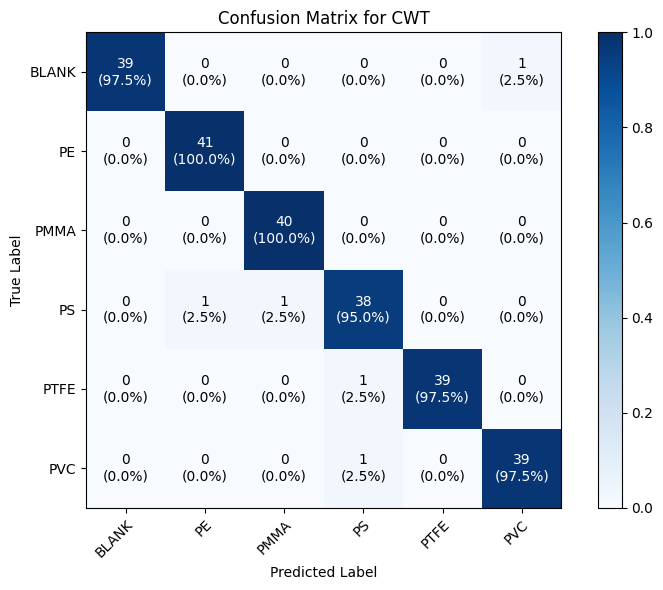

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true, pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar(im, ax=ax)

# Tick labels
class_names = list(class_map.keys())
ax.set(xticks=np.arange(len(class_names)),
       yticks=np.arange(len(class_names)),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True Label',
       xlabel='Predicted Label',
       title="Confusion Matrix for CWT")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate each cell with count and percentage
thresh = cm_normalized.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i,
                f"{cm[i, j]}\n({cm_normalized[i, j]*100:.1f}%)",
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


hybrid qft

In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import timm

# Paths
train_dir = "/content/drive/MyDrive/QFT_Spectrogram_Images_HighRes/train"
test_dir = "/content/drive/MyDrive/QFT_Spectrogram_Images_HighRes/test"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transform
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load ViT and DeiT models
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_model.head = nn.Identity()
vit_model = vit_model.to(device).eval()

deit_model = timm.create_model('deit_base_patch16_224', pretrained=True)
deit_model.head = nn.Identity()
deit_model = deit_model.to(device).eval()

# Extract hybrid features (ViT + DeiT)
def extract_hybrid_features(vit_model, deit_model, img_path):
    image = Image.open(img_path).convert("RGB")
    image = img_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        vit_feat = vit_model(image).cpu().numpy().flatten()
        deit_feat = deit_model(image).cpu().numpy().flatten()
        combined = np.concatenate((vit_feat, deit_feat))
    return combined

# Prepare dataset
def create_dataset(data_dir):
    features, labels = [], []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(data_dir)))}

    for cls_name in class_to_idx:
        cls_path = os.path.join(data_dir, cls_name)
        if os.path.isdir(cls_path):
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                feat = extract_hybrid_features(vit_model, deit_model, img_path)
                features.append(feat)
                labels.append(class_to_idx[cls_name])

    return np.array(features), np.array(labels), class_to_idx

# Load datasets
train_features, train_labels, class_map = create_dataset(train_dir)
test_features, test_labels, _ = create_dataset(test_dir)

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Cosine kNN Graph with edge weights
def create_cosine_graph(features, labels, k=10):
    cos_sim = cosine_similarity(features)
    np.fill_diagonal(cos_sim, 0)
    indices = np.argsort(-cos_sim, axis=1)[:, :k]

    rows, cols, weights = [], [], []
    for i in range(len(features)):
        for j in indices[i]:
            rows.append(i)
            cols.append(j)
            weights.append(cos_sim[i, j])

    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    edge_weight = torch.tensor(weights, dtype=torch.float)

    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y)

# Build graphs
train_graph = create_cosine_graph(train_features, train_labels, k=10)
test_graph = create_cosine_graph(test_features, test_labels, k=10)

# GCN Model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.conv2 = GCNConv(hidden_dim, out_channels)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

# Label smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# Initialize
in_dim = train_graph.x.shape[1]
out_dim = len(class_map)
gcn = GCN(in_channels=in_dim, hidden_dim=256, out_channels=out_dim).to(device)
optimizer = optim.Adam(gcn.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
criterion = LabelSmoothingLoss(classes=out_dim, smoothing=0.1)

# Training
def train(model, graph, epochs=50):
    model.train()
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        out = model(graph.x.to(device), graph.edge_index.to(device), graph.edge_weight.to(device))
        loss = criterion(out, graph.y.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()

        preds = out.argmax(dim=1).cpu().numpy()
        acc = accuracy_score(graph.y.numpy(), preds)
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {acc*100:.2f}%")

# Run training
print("Training GCN Hybrid Classifier")
train(gcn, train_graph, epochs=50)

# Evaluate
gcn.eval()
with torch.no_grad():
    out = gcn(test_graph.x.to(device), test_graph.edge_index.to(device), test_graph.edge_weight.to(device))
    pred = out.argmax(dim=1).cpu().numpy()
    true = test_graph.y.numpy()

test_acc = accuracy_score(true, pred)
print(f"\nTest Accuracy (ViT + DeiT + GCN): {test_acc * 100:.2f}%")


Training GCN Hybrid Classifier
Epoch 1/50, Loss: 2.7331, Accuracy: 14.79%
Epoch 2/50, Loss: 1.0415, Accuracy: 86.04%
Epoch 3/50, Loss: 1.1519, Accuracy: 92.08%
Epoch 4/50, Loss: 1.2994, Accuracy: 92.60%
Epoch 5/50, Loss: 1.3739, Accuracy: 91.77%
Epoch 6/50, Loss: 1.3486, Accuracy: 92.92%
Epoch 7/50, Loss: 1.2863, Accuracy: 93.75%
Epoch 8/50, Loss: 1.2405, Accuracy: 93.65%
Epoch 9/50, Loss: 1.1187, Accuracy: 93.96%
Epoch 10/50, Loss: 1.0407, Accuracy: 93.96%
Epoch 11/50, Loss: 0.9945, Accuracy: 93.02%
Epoch 12/50, Loss: 0.9790, Accuracy: 90.00%
Epoch 13/50, Loss: 0.9153, Accuracy: 91.25%
Epoch 14/50, Loss: 0.8716, Accuracy: 91.67%
Epoch 15/50, Loss: 0.8263, Accuracy: 94.06%
Epoch 16/50, Loss: 0.8079, Accuracy: 92.71%
Epoch 17/50, Loss: 0.7944, Accuracy: 91.56%
Epoch 18/50, Loss: 0.7587, Accuracy: 94.06%
Epoch 19/50, Loss: 0.7624, Accuracy: 92.81%
Epoch 20/50, Loss: 0.7671, Accuracy: 92.50%
Epoch 21/50, Loss: 0.7509, Accuracy: 93.85%
Epoch 22/50, Loss: 0.7336, Accuracy: 93.96%
Epoch 23/5

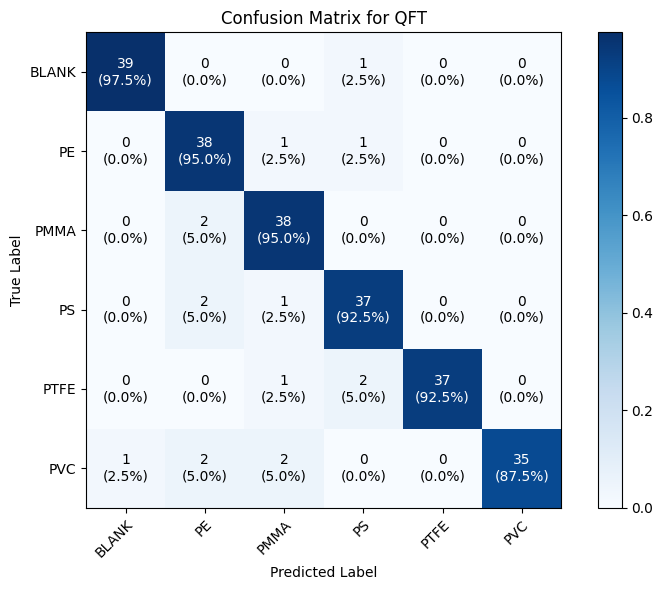

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true, pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar(im, ax=ax)

# Tick labels
class_names = list(class_map.keys())
ax.set(xticks=np.arange(len(class_names)),
       yticks=np.arange(len(class_names)),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True Label',
       xlabel='Predicted Label',
       title="Confusion Matrix for QFT")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate each cell with count and percentage
thresh = cm_normalized.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i,
                f"{cm[i, j]}\n({cm_normalized[i, j]*100:.1f}%)",
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

plots

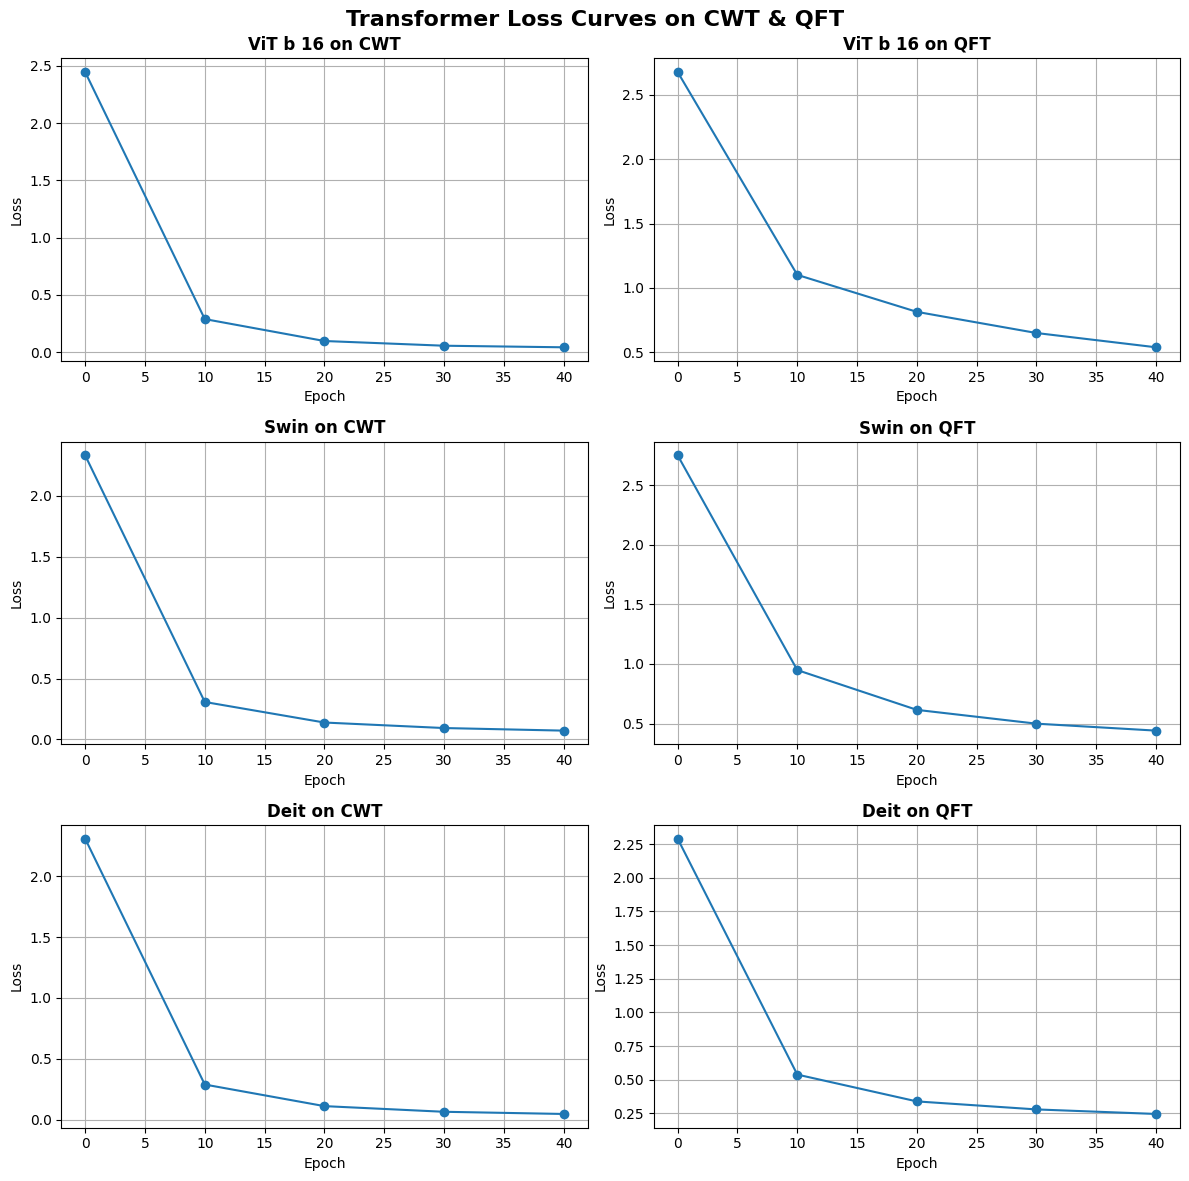

In [ ]:
import matplotlib.pyplot as plt

# Loss values
epochs_6 = [0, 10, 20, 30, 40]
epochs_10 = list(range(1, 11))

vit_cwt = [2.4450, 0.2888, 0.0974, 0.0563, 0.0425]
vit_qft = [2.6748, 1.1015, 0.8145, 0.6504, 0.5396]
swin_cwt = [2.3319, 0.3076, 0.1389, 0.0937, 0.0724]
swin_qft = [2.7482, 0.9485, 0.6149, 0.4993, 0.4409]
deit_cwt = [2.3068, 0.2888, 0.1116, 0.0651, 0.0472]
deit_qft = [2.2894, 0.5379, 0.3386, 0.2791, 0.2454]

# Create subplots (3 rows, 2 cols) with increased spacing
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle("Transformer Loss Curves on CWT & QFT", fontsize=16, fontweight="bold")

# Adjust spacing to prevent text overlap
fig.subplots_adjust(hspace=0.4)

# Plot first 6 models
titles = ["ViT b 16 on CWT", "ViT b 16 on QFT", "Swin on CWT", "Swin on QFT", "Deit on CWT", "Deit on QFT"]
data = [vit_cwt, vit_qft, swin_cwt, swin_qft, deit_cwt, deit_qft]

for i, ax in enumerate(axes.flatten()):
    ax.plot(epochs_6, data[i], marker="o", linestyle="-", markersize=6)
    ax.set_title(titles[i], fontsize=12, fontweight="bold")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True)

# Show plots
plt.tight_layout()
plt.show()


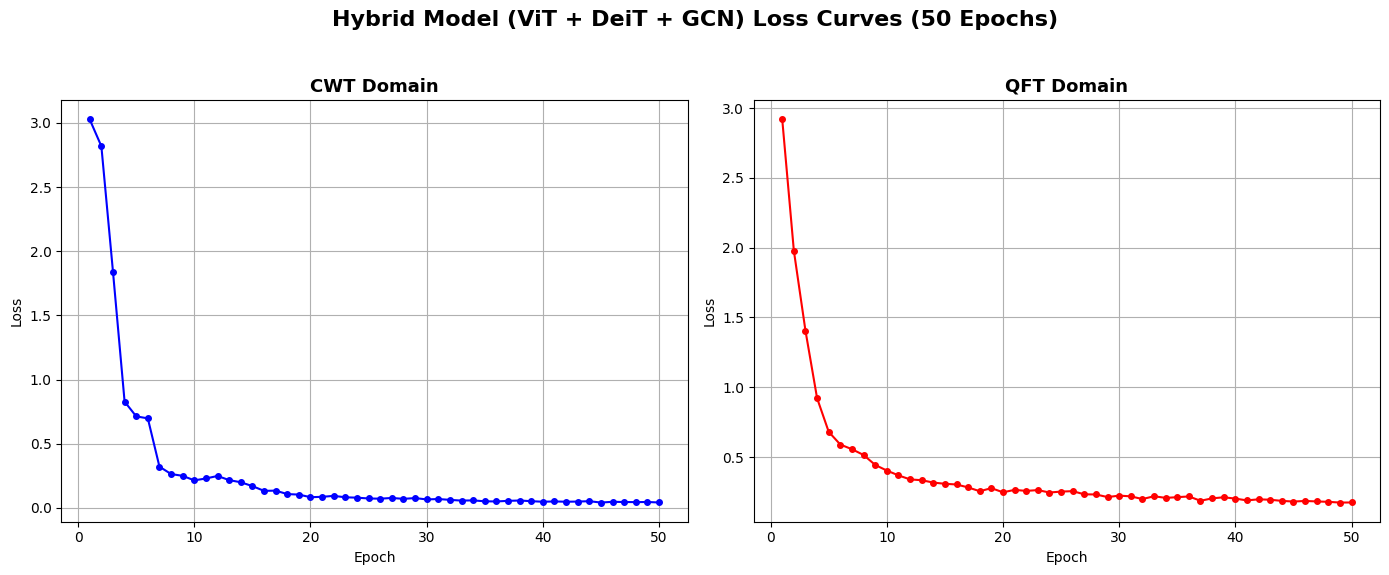

In [ ]:
import matplotlib.pyplot as plt

# Epochs from 1 to 50
epochs_50 = list(range(1, 51))

# New loss values
hybrid_cwt = [
    3.0273, 2.8190, 1.8407, 0.8280, 0.7130, 0.6973, 0.3209, 0.2634, 0.2493, 0.2141,
    0.2288, 0.2484, 0.2161, 0.1993, 0.1694, 0.1323, 0.1340, 0.1072, 0.1032, 0.0828,
    0.0857, 0.0932, 0.0822, 0.0791, 0.0730, 0.0712, 0.0769, 0.0700, 0.0760, 0.0655,
    0.0686, 0.0621, 0.0563, 0.0580, 0.0509, 0.0496, 0.0544, 0.0569, 0.0518, 0.0474,
    0.0498, 0.0475, 0.0488, 0.0517, 0.0410, 0.0470, 0.0453, 0.0445, 0.0455, 0.0417
]

hybrid_qft = [
    2.9182, 1.9780, 1.4049, 0.9217, 0.6811, 0.5898, 0.5565, 0.5151, 0.4440, 0.4036,
    0.3692, 0.3402, 0.3344, 0.3176, 0.3087, 0.3039, 0.2828, 0.2555, 0.2776, 0.2478,
    0.2652, 0.2579, 0.2637, 0.2463, 0.2529, 0.2561, 0.2333, 0.2324, 0.2136, 0.2240,
    0.2189, 0.1994, 0.2196, 0.2078, 0.2129, 0.2182, 0.1871, 0.2044, 0.2122, 0.2026,
    0.1898, 0.1976, 0.1945, 0.1864, 0.1816, 0.1858, 0.1824, 0.1796, 0.1743, 0.1750
]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Hybrid Model (ViT + DeiT + GCN) Loss Curves (50 Epochs)", fontsize=16, fontweight="bold")

# CWT Loss Plot
axes[0].plot(epochs_50, hybrid_cwt, marker="o", linestyle="-", markersize=4, color="blue")
axes[0].set_title("CWT Domain", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True)

# QFT Loss Plot
axes[1].plot(epochs_50, hybrid_qft, marker="o", linestyle="-", markersize=4, color="red")
axes[1].set_title("QFT Domain", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)

# Layout adjustment
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
